# Notebook 1: Visualizing and exploring the data

In this notebook we visualize the data with the force layout embedding (FLE), and examine patterns and programs of gene expression in the visualization. We identify sets of cells with coherent expression patterns.



In [ ]:
import ipywidgets as widgets
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import wot

# Load input data

The `data/` folder in the `wot/notebooks/data` directory contains all the input files used throughout this tutorial. 

At a bare minimum, you technically only need two files to compute transport maps for your data:

* an expression matrix: `ExprMatrix.h5ad`
* a cell days file: `cell_days.txt`

The expression matrix is formatted with cells on the rows and genes on the columns. Each cell is annotated with a unique barcode, which is used to identify the cell. The cell days file has two columns: one with cell IDs and one with the time of collection. 

It's also super helpful to have a good visualization of the data. Visualizing high dimensional data is an active area of research in single cell analysis, and there are many good packages for this. The visualization coordinates from our paper [Schiebinger et al 2019](https://www.cell.com/cell/fulltext/S0092-8674(19)30039-X) are here:

* visualization coordinates: `fle_coords.txt`

We provide code to compute FLE coordinates at the end of this notebook, but note that the output will look different because the random seed is different. 

The following code block loads the data into memory and plots FLE coordinates colored by day. 

Text(0.5, 1.0, 'Day')

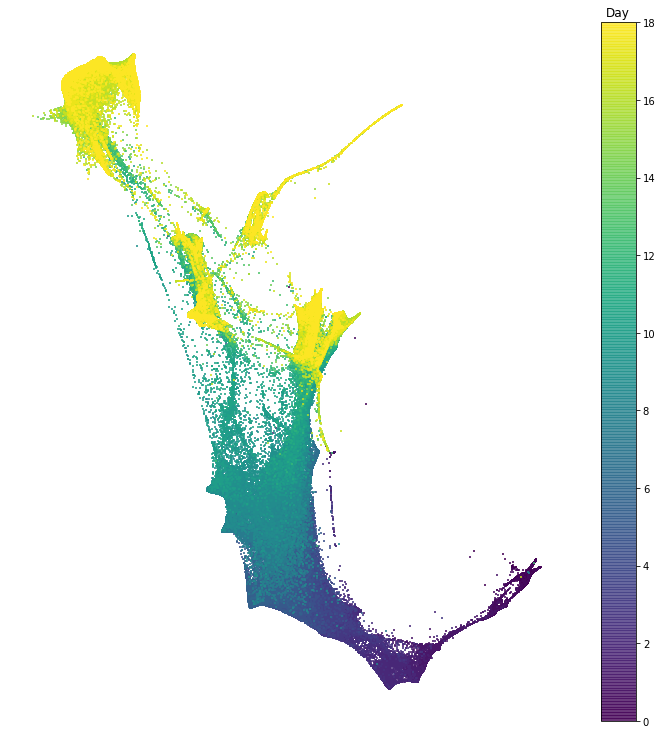

In [2]:
# Path to input files
FLE_COORDS_PATH ='data/fle_coords.txt'
FULL_DS_PATH = 'data/ExprMatrix.h5ad'
VAR_DS_PATH = 'data/ExprMatrix.var.genes.h5ad'
CELL_DAYS_PATH = 'data/cell_days.txt'
GENE_SETS_PATH = 'data/gene_sets.gmx'
GENE_SET_SCORES_PATH = 'data/gene_set_scores.csv'
CELL_SETS_PATH = 'data/cell_sets.gmt'

coord_df = pd.read_csv(FLE_COORDS_PATH, index_col='id', sep='\t')
days_df = pd.read_csv(CELL_DAYS_PATH, index_col='id', sep='\t')

# Read expression matrix, cell days, and 2-d coordinates
adata = wot.io.read_dataset(FULL_DS_PATH, obs=[days_df,coord_df])
unique_days = adata.obs['day'].unique()
unique_days = unique_days[np.isnan(unique_days) == False]
# plot visualization coordinates
figure = plt.figure(figsize=(10, 10))
plt.axis('off')
plt.tight_layout()
plt.scatter(adata.obs['x'], adata.obs['y'],c=adata.obs['day'],
               s=4, marker=',', edgecolors='none', alpha=0.8)
cb = plt.colorbar()
cb.ax.set_title('Day')

# Compute gene signature scores

We next score each cell according to its expression of various gene signatures. 
To do this, we test whether the set of genes in a signature is significantly expressed in each cell. 

The file `data/gene_sets.gmx` contains gene sets relevant to our reprogramming database, as explained in Schiebinger et al 2019. For a different application, you will need to use different gene sets. 


In [3]:
gs = wot.io.read_sets(GENE_SETS_PATH, adata.var.index.values)
gene_set_scores_df = pd.DataFrame(index=adata.obs.index)
for j in range(gs.shape[1]):
    gene_set_name = str(gs.var.index.values[j])
    result = wot.score_gene_sets(ds=adata, gs=gs[:, [j]], permutations=0, method='mean_z_score')
    gene_set_scores_df[gene_set_name] = result['score']
gene_set_scores_df.to_csv(GENE_SET_SCORES_PATH, index_label='id')

We can then visualize these scores on the FLE coordinates.

In [4]:
gene_set_scores_df = pd.read_csv(GENE_SET_SCORES_PATH,index_col='id')
gene_set_dropdown = widgets.Dropdown(
    options=gene_set_scores_df.columns,
    description='Gene Set:'
)

gene_set_scores_df = gene_set_scores_df.join(coord_df).join(days_df)
day_selector = widgets.SelectionRangeSlider(
    options=unique_days,
    continuous_update=False,
    index=(0,len(unique_days)-1),
    description='Days'
)

def update_gene_set_vis(name, days):
    gene_set_score_coords = gene_set_scores_df[(gene_set_scores_df['day']>=days[0]) & (gene_set_scores_df['day']<=days[1])]
    figure = plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.tight_layout()
    plt.title(name + ', days {}-{}'.format(days[0], days[1]))
    plt.scatter(coord_df['x'], coord_df['y'], c='#f0f0f0',
                   s=4, marker=',', edgecolors='none', alpha=0.8)
    plt.scatter(gene_set_score_coords['x'], gene_set_score_coords['y'], c=gene_set_score_coords[name],
                   s=4, marker=',', edgecolors='none')
    cb = plt.colorbar()
    cb.ax.set_title('Signature')
    figure2 = plt.figure(figsize=(10, 5))
    plt.title(name + ', days {}-{}'.format(days[0], days[1]))
    plt.hist(gene_set_score_coords[name])
    return figure, figure2

widgets.interact(update_gene_set_vis, name=gene_set_dropdown, days=day_selector)

interactive(children=(Dropdown(description='Gene Set:', options=('MEF.identity', 'Pluripotency', 'Cell.cycle',…

<function __main__.update_gene_set_vis(name, days)>

# Cell Sets

Some of our interpretation of transport maps will be based on grouping cells into sets with coherent expression (e.g. iPSCs). 
We recommend that the user define cell sets through a combination of clustering and using gene signature scores. 

In the following code block we load and visualize the cell sets defined in Schiebinger et al 2019. In the following notebooks, we will use optimal transport to examine the developmental trajectories leading to these cell sets.

In [5]:
# Load cell sets
cell_sets = wot.io.read_sets(CELL_SETS_PATH)

# Visualize Cell Sets 
cell_set_dropdown = widgets.Dropdown(
    options=cell_sets.var.index,
    description='Cell Set:'
)

day_selector = widgets.SelectionRangeSlider(
    options=unique_days,
    continuous_update=False,
    index=(0,len(unique_days)-1),
    description='Days'
)

def update_cell_set_vis(name, days):
    cell_set = cell_sets[:, name]
    cell_set_coords = cell_set[cell_set.X>0].obs.join(coord_df).join(days_df)
    cell_set_coords = cell_set_coords[(cell_set_coords['day']>=days[0]) & (cell_set_coords['day']<=days[1])]
    figure = plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.tight_layout()
    plt.title(name + ', days {}-{}, {:,} cells'.format(days[0], days[1], cell_set_coords.shape[0]))
    plt.scatter(coord_df['x'], coord_df['y'], c='#f0f0f0',
                   s=4, marker=',', edgecolors='none', alpha=0.8)
    plt.scatter(cell_set_coords['x'], cell_set_coords['y'], c=cell_set_coords['day'],
                   s=4, marker=',', edgecolors='none', vmin=unique_days[0],  vmax=unique_days[len(unique_days)-1])
    cb = plt.colorbar()
    cb.ax.set_title('Day')

widgets.interact(update_cell_set_vis, name=cell_set_dropdown, days=day_selector)

interactive(children=(Dropdown(description='Cell Set:', options=('IPS', 'Stromal', 'Neural', 'MET', 'Epithelia…

<function __main__.update_cell_set_vis(name, days)>

# Optional: compute force layout embedding coordinates

Visualizing high dimensional data is an active area of research in single cell analysis, and there are lots of good methods and software packages out there.

The force layout embedding (FLE) is a graph visualization tool which we apply to layout a nearest neighbor graph constructed from our single cell gene expression data. There is a node for each cell, and each cell is connected to its k nearest neighbors. Then the cells are arranged in 2D so that cells connected by an edge attract, and cells not connected by an edge repel each other. 

The commands below compute the FLE coordinates. 
Note that the output will look different than the coordinates from our paper because the random seed is different. In our paper, we used [Gephi](https://gephi.org/) to interactively compute the FLE. Since then, we have [modified the Gephi source code](https://github.com/klarman-cell-observatory/forceatlas2). 

Compute neighborhood graph and save in gexf format for running force atlas

In [6]:
# adata_fle = wot.io.read_dataset(VAR_DS_PATH)
# wot.neighborhood_graph.compute_neighborhood_graph(adata_fle, space='dmap', neighbors=50, pca_comps=100, diff_comps=20)
# wot.neighborhood_graph.graph_to_gexf(adata_fle, 'fle-input.gexf')

Download force atlas library

In [ ]:
# !wget https://github.com/klarman-cell-observatory/forceatlas2/releases/download/1.0.3/forceatlas2.jar
# !wget https://github.com/klarman-cell-observatory/forceatlas2/releases/download/1.0.3/gephi-toolkit-0.9.2-all.jar

Run force atlas, if you remove the --2d flag above, it computes 3d coordinates.

In [ ]:
# !java -Xmx8g -cp forceatlas2.jar:gephi-toolkit-0.9.2-all.jar kco.forceatlas2.Main --input fle-input.gexf --output fle_coords_new --2d --seed 1234 --nsteps 1000

Examine convergence and plot FLE

In [ ]:
# coords_df = pd.read_csv('fle_coords_new.txt', sep='\t', index_col=0)
# convergence_df = pd.read_csv('fle_coords_new.distances.txt', sep='\t')
# convergence_df.plot(x='step', y='distance', figsize=(10, 5))

# figure = plt.figure(figsize=(10, 10))
# plt.axis('off')
# plt.tight_layout()
# plt.scatter(coords_df['x'], coords_df['y'],c=adata.obs['day'],
#                s=4, marker=',', edgecolors='none', alpha=0.8)
# cb = plt.colorbar()
# cb.ax.set_title('Day')